# 1.2 données temporelles

### 1.2.1 Prétraitement 


In [174]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import statistics
import math
import random
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

Chargement du dataset 2:

In [175]:
datas2 = pd.read_csv('Dataset2.csv')
datas2 = datas2.replace({pd.NA: np.nan})
dataset = datas2.to_numpy()

numeric_columns = datas2.select_dtypes(include=['int', 'float']).columns.tolist() # column label
numeric_columns = [datas2.columns.get_loc(col) for col in numeric_columns] #column index

# types des attributs
print("Types des différents attributs : ", [type(att) for att in dataset[0, :]])

# 10 premières instances du dataset 2
print(dataset[:10])

Types des différents attributs :  [<class 'int'>, <class 'int'>, <class 'int'>, <class 'str'>, <class 'str'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
[[95129 32 39741 '10/11/2020' '10/31/2020' 22.0 2543.0 23.0 2.6 304.7 0.9]
 [95129 43 39741 '5/30/2021' '6/19/2021' nan 3315.0 14.0 1.1 397.2 0.4]
 [95129 40 39741 '3/28/2021' '4/17/2021' 34.0 4816.0 37.0 4.1 577.1 0.8]
 [95129 55 39741 '2/6/2022' '2/26/2022' 110.0 10194.0 175.0 13.2 1221.5
  1.7]
 [95129 44 39741 '6/20/2021' '7/10/2021' 14.0 3033.0 17.0 1.7 363.4 0.6]
 [95129 54 39741 '1/16/2022' '2/5/2022' 624.0 13479.0 817.0 74.8 1615.1
  6.1]
 [95129 25 39741 '5/17/2020' '6/6/2020' nan 762.0 nan 0.4 91.3 0.4]
 [95129 30 39741 '8/30/2020' '9/19/2020' 20.0 1773.0 20.0 2.4 212.4 1.1]
 [95129 31 39741 '9/20/2020' '10/10/2020' 12.0 2120.0 12.0 1.4 254.0 0.6]
 [95129 66 39741 '9/25/2022' '10/15/2022' 66.0 1571.0 78.0 7.9 188.2 5.0]]


Définir un mapping d'années pour les dates qui n'ont pas d'année :

In [176]:
datas2['Start date'] = pd.to_datetime(datas2['Start date'], errors='coerce')
datas2['end date'] = pd.to_datetime(datas2['end date'], errors='coerce')

yearly_intervals = datas2.groupby((datas2['Start date'].dt.year))['time_period'].agg(['min', 'max'])

year_mapping = {}

for year, interval in yearly_intervals.iterrows():
    year_mapping[(interval['min'], interval['max'])] = int(year)

print(year_mapping)

{(18, 18): 2019, (19, 35): 2020, (36, 53): 2021, (54, 155): 2022}


Définir une fonction pour le traitement des dates :

In [177]:
def convert_date(time_period, date, year_mapping):
    date = str(date)
    dd_mm_yy = re.compile(r'\b\d{1,2}/\d{1,2}/\d{4}\b')
    dd_mmm = re.compile(r'\b\d{1,2}-[a-zA-Z]{3}\b')

    if dd_mm_yy.match(date):
        formatted_date = datetime.strptime(date, '%m/%d/%Y')
        return np.datetime64(formatted_date)
    elif dd_mmm.match(date):
        day, month = date.split('-')
        month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
        month = month_dict[month]
        for interval, y in year_mapping.items():
            if interval[0] <= int(time_period) <= interval[1]:
                year = y
                break
        return np.datetime64(datetime(int(year), month, int(day)))
    else:
        return None

In [178]:
for row in dataset:
    row[3] = convert_date(row[1], row[3], year_mapping)
    row[4] = convert_date(row[1], row[4], year_mapping)

print(dataset[:, 3:5])

[[numpy.datetime64('2020-10-11T00:00:00.000000')
  numpy.datetime64('2020-10-31T00:00:00.000000')]
 [numpy.datetime64('2021-05-30T00:00:00.000000')
  numpy.datetime64('2021-06-19T00:00:00.000000')]
 [numpy.datetime64('2021-03-28T00:00:00.000000')
  numpy.datetime64('2021-04-17T00:00:00.000000')]
 [numpy.datetime64('2022-02-06T00:00:00.000000')
  numpy.datetime64('2022-02-26T00:00:00.000000')]
 [numpy.datetime64('2021-06-20T00:00:00.000000')
  numpy.datetime64('2021-07-10T00:00:00.000000')]
 [numpy.datetime64('2022-01-16T00:00:00.000000')
  numpy.datetime64('2022-02-05T00:00:00.000000')]
 [numpy.datetime64('2020-05-17T00:00:00.000000')
  numpy.datetime64('2020-06-06T00:00:00.000000')]
 [numpy.datetime64('2020-08-30T00:00:00.000000')
  numpy.datetime64('2020-09-19T00:00:00.000000')]
 [numpy.datetime64('2020-09-20T00:00:00.000000')
  numpy.datetime64('2020-10-10T00:00:00.000000')]
 [numpy.datetime64('2022-09-25T00:00:00.000000')
  numpy.datetime64('2022-10-15T00:00:00.000000')]
 [numpy.da

#### - Traitement des val manquantes

On a deux méthodes: remplacment par le mode ou par la moyenne comme suit :

In [179]:
def mode(data_column):
    freq = {}
    max_freq = 0
    modes = []

    for val in data_column:
        if not np.isnan(val):
            if val in freq:
                freq[val] += 1
            else:
                freq[val] = 1
                
            if freq[val] > max_freq:
                max_freq = freq[val]
                modes = [val]
            elif freq[val] == max_freq:
                modes.append(val)
    return modes

In [180]:
def replace_missing_values(method, attribut):
    missing = [i for i, val in enumerate(dataset[:, attribut]) if np.isnan(val)]

    for i in missing:
        zone = dataset[i, 0]
        time_period = dataset[i, 1]
        matching_rows = [z for z in range(dataset.shape[0]) if dataset[z, 1] == time_period and not np.isnan(dataset[z, attribut])]
        if method == "Mode":
            if matching_rows:
                modes = mode(dataset[matching_rows, attribut])
                dataset[i, attribut] = np.random.choice(modes, size=1)
            else:
                zone_rows = [z for z in range(dataset.shape[0]) if dataset[z, 0] == zone and not np.isnan(dataset[z, attribut])]
                modes = mode(dataset[zone_rows, attribut])
                dataset[i, attribut] = np.random.choice(modes, size=1)
        else:
            if matching_rows:
                mean_val = np.mean(dataset[matching_rows, attribut])
                dataset[i, attribut] = mean_val
            else:
                zone_rows = [z for z in range(dataset.shape[0]) if dataset[z, 0] == zone and not np.isnan(dataset[z, attribut])]
                mean_val = np.mean(dataset[zone_rows, attribut])
                dataset[i, attribut] = mean_val

def replace_missing_values_general(method):
    for attribute_index in numeric_columns:
        replace_missing_values(method, attribute_index)


In [181]:
print(dataset[6])
replace_missing_values_general("Moyenne")
print(dataset[6])

[95129 25 39741 numpy.datetime64('2020-05-17T00:00:00.000000')
 numpy.datetime64('2020-06-06T00:00:00.000000') nan 762.0 nan 0.4 91.3 0.4]
[95129 25 39741 numpy.datetime64('2020-05-17T00:00:00.000000')
 numpy.datetime64('2020-06-06T00:00:00.000000') 22.0 762.0
 27.333333333333332 0.4 91.3 0.4]


#### - Traitement des val aberrantes

On a implémenté deux méthodes de remplacement des valeurs aberrante : descritisation et regréssion linéaire :

In [182]:
def mediane(dataset):
     n = len(dataset) 
     dataset = sorted(dataset)
     
     if n % 2 == 0:
          return (dataset[(n // 2) - 1] + dataset[n // 2]) / 2
     else:
          return dataset[n // 2]
     
def quartiles(dataset):
    dataset = sorted(dataset)
    n = len(dataset)
    q0 = dataset[0]
    q2 = mediane(dataset)
    q4 = dataset[n - 1]

    if n % 2 == 0:
        q1 = (dataset[(n // 2) // 2 - 1] + dataset[(n // 2 // 2)]) / 2    
        q3 = (dataset[3 * (n // 2) // 2 - 1] + dataset[3 * (n // 2) // 2]) / 2
    else:
        q1 = dataset[n // 4]
        q3 = dataset[n * 3 // 4]

    return q0, q1, q2, q3, q4

In [183]:
def Discretisation2(attribut):
    global dataset
    vals=dataset[:,attribut].copy()
    vals.sort()
    q = 1+(10/3)*np.log10(dataset.shape[0])
    nbrelmt=math.ceil(dataset[:,attribut].shape[0]/q)

    for  val in range(0,dataset[:,attribut].shape[0]):
        for i in range(0,vals.shape[0],nbrelmt):
            if(vals[i]>dataset[val,attribut]):
                sup=i
                break
        dataset[val,attribut]=np.mean(vals[sup-nbrelmt:sup])

In [184]:
from sklearn import linear_model
np.random.seed(42)

def replace_outliers(method,attribut):
    abberante=[]

    if method=='Linear Regression':
        col = dataset[:, attribut]
        IQR=(np.percentile(col, 75)-np.percentile(col, 25))*1.5
        for i in range(0,len(col)):
            if (dataset[i,attribut] >(np.percentile(col, 75)+IQR) or dataset[i,attribut]<(np.percentile(col, 25)-IQR)):
                abberante.append(i)
    
        X = np.delete(dataset, attribut, axis=1)
        X = np.delete(X, abberante, axis=0)
        y=dataset[:,attribut]
        y= np.delete(y, abberante, axis=0).reshape(-1, 1)
        model = linear_model.LinearRegression().fit(X, y)
         
        for i in abberante:
            x2=np.delete(dataset, attribut, axis=1)
            X_new =x2[i,:].T.reshape(1, -1)
            dataset[i,attribut]=model.predict(X_new)[0][0]

    else:
         Discretisation2(attribut)

def replace_outliers_general(method):
    for attribute_index in numeric_columns:
        replace_outliers(method, attribute_index)

In [185]:
print(dataset[48, 1])
replace_outliers_general("Linear Regression")
print(dataset[48, 1])

155


55.0


### 1.2.2 Visualisation : Graphes

In [186]:
header = ['zcta', 'time_period', 'population', 'Start date', 'end date', 'case count', 'test count', 'positive tests', 'case rate', 'test rate', 'positivity rate']
df = pd.DataFrame(dataset, columns=header)

- La distribution du nombre total des cas confirmés et tests positifs par zones :

    zcta    case count positive tests
0  94085    5472.66038    6616.077014
1  94086   7456.239116    8975.785211
2  94087   7383.129888    8684.222835
3  95035   11055.43338   12999.102933
4  95127  15291.917755   18140.869287
5  95128   9218.699099   10811.674139
6  95129   6317.336215    7435.638395


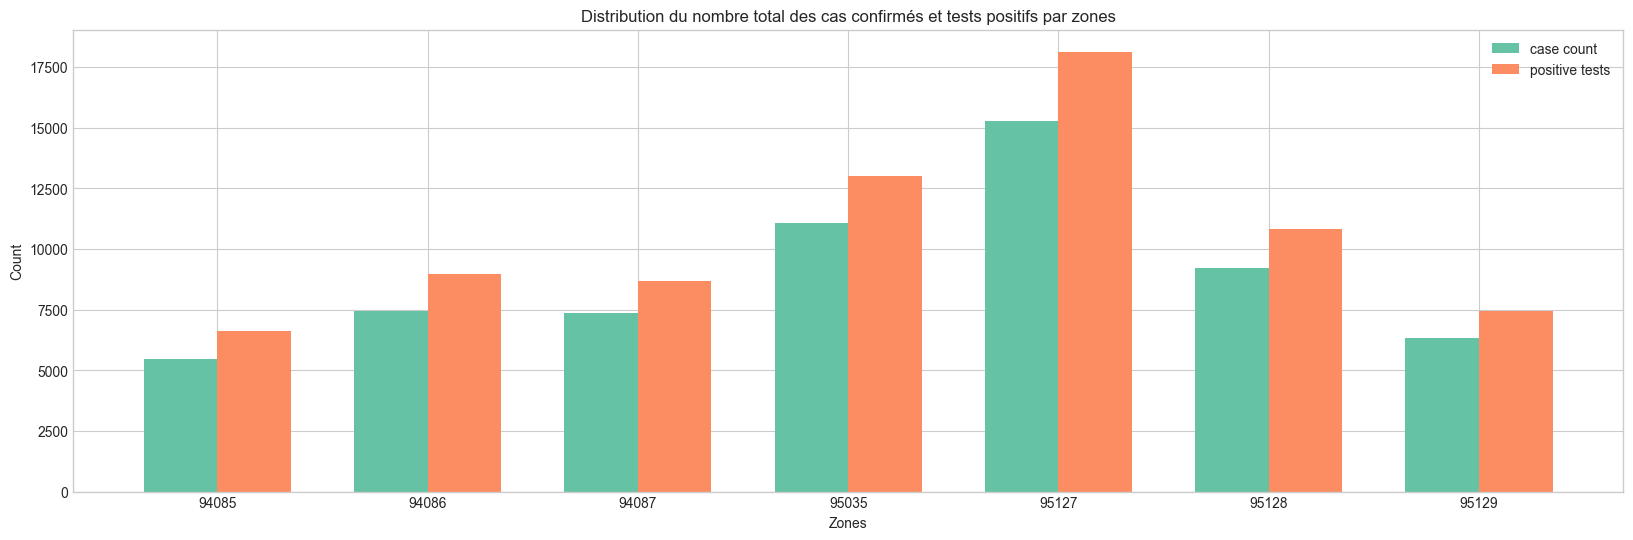

In [198]:
# Bar chart
def plot_total_cases_and_positive_tests():
    totals = df.groupby('zcta')[['case count', 'positive tests']].sum().reset_index()
    zones = totals['zcta'].tolist()
    print(totals)

    fig, ax = plt.subplots(figsize=(20, 6))
    bar_width = 0.35
    index = totals.index

    ax.bar(index, totals['case count'], bar_width, label='case count')
    ax.bar(index + bar_width, totals['positive tests'], bar_width, label='positive tests')

    ax.set_xlabel('Zones')
    ax.set_ylabel('Count')
    ax.set_title('Distribution du nombre total des cas confirmés et tests positifs par zones')
    ax.set_xticks(index+bar_width/2)
    ax.set_xticklabels(zones)
    ax.legend()

    plt.show()

plot_total_cases_and_positive_tests()

# Tree map
def plot_total_cases_and_positive_tests_treemap():
    totals = df.groupby('zcta')[['case count', 'positive tests']].sum().reset_index()

    fig = px.treemap(totals, path=['zcta'], values='case count', title='Total Case Count by ZCTA')
    fig.show()

    fig = px.treemap(totals, path=['zcta'], values='positive tests', title='Total Positive Tests by ZCTA')
    fig.show()

plot_total_cases_and_positive_tests_treemap()



- Comment les tests COVID-19, les tests positifs et le nombre de cas évolue au fil du temps (hebdomadaire, mensuel et annuel) pour une zone choisit :

    test count case count positive tests Start date   end date
262     6882.0      150.0          179.0 2021-08-22 2021-09-11
266     5524.0      104.0          114.0 2021-08-01 2021-08-21


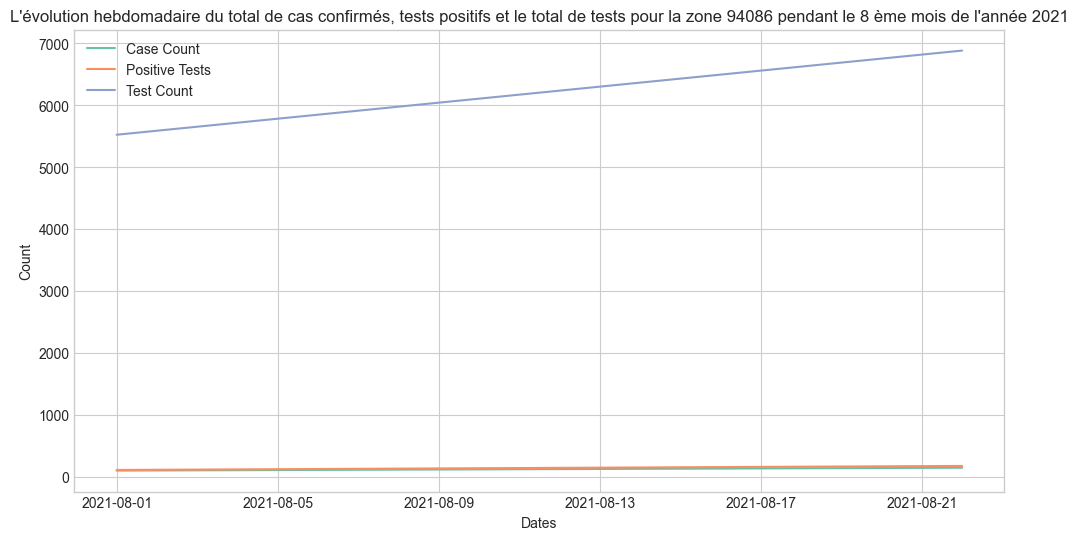

   test count   case count positive tests
0     12780.0        531.0          601.0
1      5461.0         75.0           88.0
2     11383.0        103.0          131.0
3      5270.0         55.0           68.0
4      7803.0         32.5      41.666667
5      3025.0         19.0           21.0
6      3834.0         75.0           90.0
7     12406.0        254.0          293.0
8      7362.0         48.0           66.0
9     13343.0         97.0          117.0
10     6659.0         58.0           72.0
11    18249.0  1239.328516    1465.386205


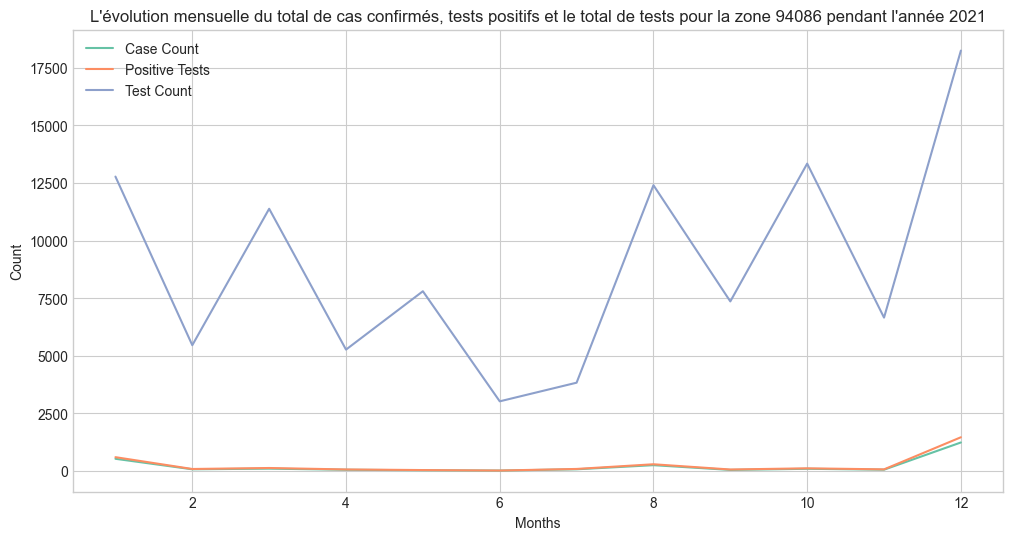

   Year   case count positive tests    test count
0  2019          0.0     224.744681   4084.262411
1  2020      1240.75    1532.489362  40875.319149
2  2021  2586.828516    3054.052872      107575.0
3  2022  3628.660601    4164.498297       58892.0


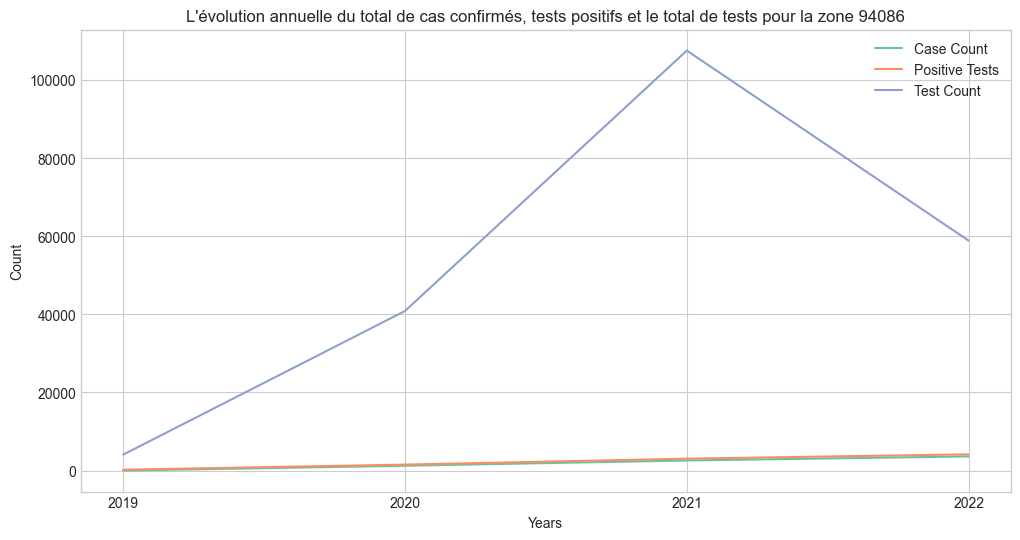

In [199]:
def visualize_data_general(chosen_zone, chosen_year, chosen_month):
    
    df['Start date'] = pd.to_datetime(df['Start date'])
    df['end date'] = pd.to_datetime(df['end date'])

    df['Month'] = df['Start date'].dt.month
    df['Year'] = df['Start date'].dt.year

    zone_df = df[df['zcta'] == chosen_zone]

    # Visualisation hebdomadaire
    plt.figure(figsize=(12, 6))
    hebdo_df = zone_df[(zone_df['Month'] == chosen_month) & (zone_df['Year'] == chosen_year)]
    print(hebdo_df[['test count', 'case count', 'positive tests', 'Start date', 'end date']])

    sns.lineplot(x='Start date', y='case count', data=hebdo_df, label='Case Count')
    sns.lineplot(x='Start date', y='positive tests', data=hebdo_df, label='Positive Tests')
    sns.lineplot(x='Start date', y='test count', data=hebdo_df, label='Test Count')
    plt.title(f'L\'évolution hebdomadaire du total de cas confirmés, tests positifs et le total de tests pour la zone {chosen_zone} pendant le {chosen_month} ème mois de l\'année {chosen_year}')
    plt.xlabel('Dates')
    plt.ylabel('Count') 
    plt.legend()
    plt.show()


    # Visualisation mensuelle
    plt.figure(figsize=(12, 6))
    monthly_df = zone_df[zone_df['Year'] == chosen_year]
    month_df = monthly_df.groupby('Month')[['case count', 'positive tests', 'test count']].sum().reset_index()
    print(month_df[['test count', 'case count', 'positive tests']])

    sns.lineplot(x='Month', y='case count', data=month_df, label='Case Count')
    sns.lineplot(x='Month', y='positive tests', data=month_df, label='Positive Tests')
    sns.lineplot(x='Month', y='test count', data=month_df, label='Test Count')    
    plt.title(f'L\'évolution mensuelle du total de cas confirmés, tests positifs et le total de tests pour la zone {chosen_zone} pendant l\'année {chosen_year}')
    plt.xlabel('Months')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    

    # Visualisation annuelle
    plt.figure(figsize=(12, 6))
    annual_df = zone_df.groupby('Year')[['case count', 'positive tests', 'test count']].sum().reset_index()
    annual_df['Year'] = annual_df['Year'].astype(int)
    print(annual_df)
    
    sns.lineplot(x='Year', y='case count', data=annual_df, label='Case Count')
    sns.lineplot(x='Year', y='positive tests', data=annual_df, label='Positive Tests')
    sns.lineplot(x='Year', y='test count', data=annual_df, label='Test Count')
    plt.title(f'L\'évolution annuelle du total de cas confirmés, tests positifs et le total de tests pour la zone {chosen_zone}')
    plt.xlabel('Years')
    plt.ylabel('Count')
    plt.xticks(annual_df['Year'])
    plt.legend()
    plt.show()
    

visualize_data_general(chosen_zone=94086, chosen_year=2021, chosen_month=8)


The most frequent month for the chosen zone is: 8


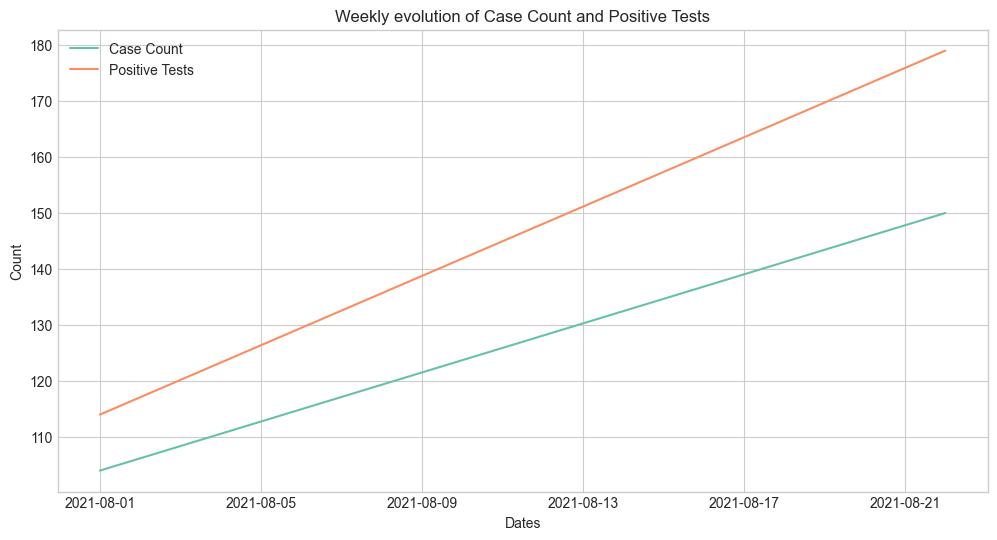

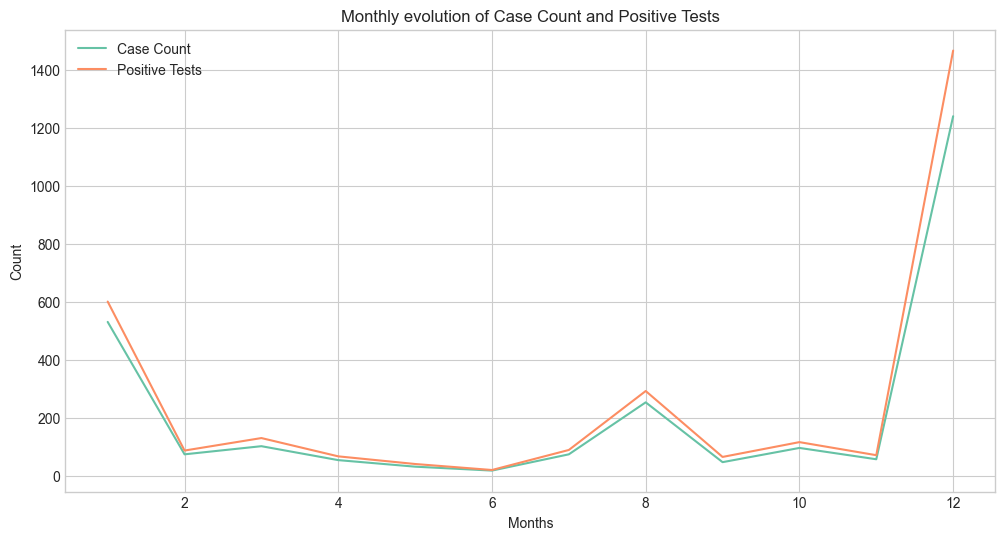

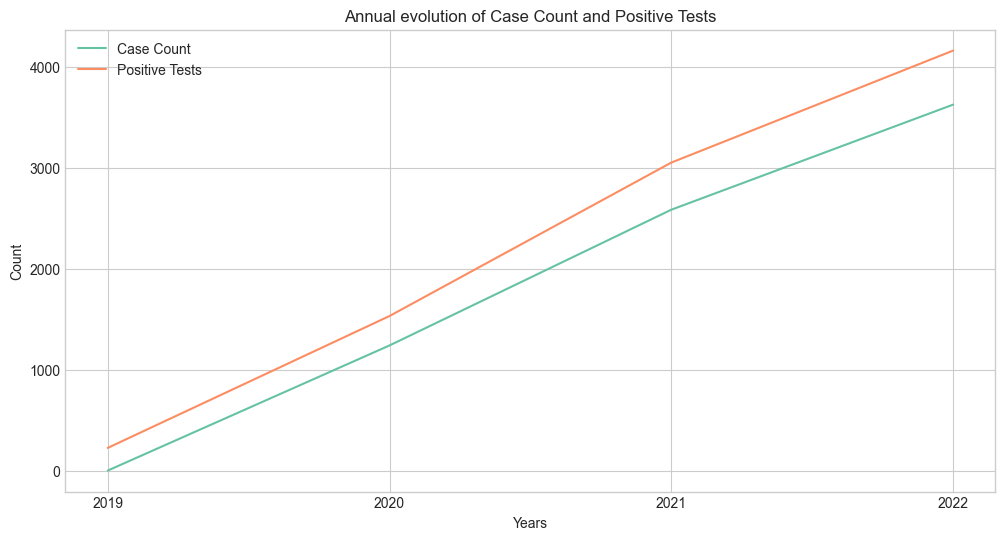

In [200]:
def visualize_data(chosen_zone, chosen_year, chosen_month):
    df['Start date'] = pd.to_datetime(df['Start date'])
    df['end date'] = pd.to_datetime(df['end date'])

    df['Month'] = df['Start date'].dt.month
    df['Year'] = df['Start date'].dt.year

    zone_df = df[df['zcta'] == chosen_zone]

    most_frequent_month = zone_df['Month'].value_counts().idxmax()
    print("The most frequent month for the chosen zone is:", most_frequent_month)

    # Visualisation hebdomadaire
    plt.figure(figsize=(12, 6))
    hebdo_df = zone_df[(zone_df['Month'] == chosen_month) & (zone_df['Year'] == chosen_year)]

    sns.lineplot(x='Start date', y='case count', data=hebdo_df, label='Case Count')
    sns.lineplot(x='Start date', y='positive tests', data=hebdo_df, label='Positive Tests')
    plt.title('Weekly evolution of Case Count and Positive Tests')
    plt.xlabel('Dates')
    plt.ylabel('Count') 
    plt.legend()
    plt.show()

    # Visualisation mensuelle
    plt.figure(figsize=(12, 6))
    monthly_df = zone_df[zone_df['Year'] == chosen_year]
    month_df = monthly_df.groupby('Month')[['case count', 'positive tests']].sum().reset_index()

    sns.lineplot(x='Month', y='case count', data=month_df, label='Case Count')
    sns.lineplot(x='Month', y='positive tests', data=month_df, label='Positive Tests')
    plt.title('Monthly evolution of Case Count and Positive Tests')
    plt.xlabel('Months')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Visualisation annuelle
    plt.figure(figsize=(12, 6))
    annual_df = zone_df.groupby('Year')[['case count', 'positive tests']].sum().reset_index()
    annual_df['Year'] = annual_df['Year'].astype(int)

    sns.lineplot(x='Year', y='case count', data=annual_df, label='Case Count')
    sns.lineplot(x='Year', y='positive tests', data=annual_df, label='Positive Tests')
    plt.title('Annual evolution of Case Count and Positive Tests')
    plt.xlabel('Years')
    plt.ylabel('Count')
    plt.xticks(annual_df['Year'])
    plt.legend()
    plt.show()

visualize_data(chosen_zone=94086, chosen_year=2021, chosen_month=8)


- Comment les cas covid positifs sont distribués par zone et par année ?

zcta        94085        94086        94087        95035        95127  \
Year                                                                    
2019          0.0          0.0          NaN          NaN          0.0   
2020       828.25      1240.75        884.5  1765.332974  3919.554759   
2021  2385.152554  2586.828516  2637.034892  4190.376363  6079.638409   
2022  2259.257826  3628.660601  3861.594996  5099.724043  5292.724587   

zcta        95128        95129  
Year                            
2019          0.0          NaN  
2020  1880.043883       797.25  
2021  3559.351923  2222.238623  
2022  3779.303293  3297.847592  


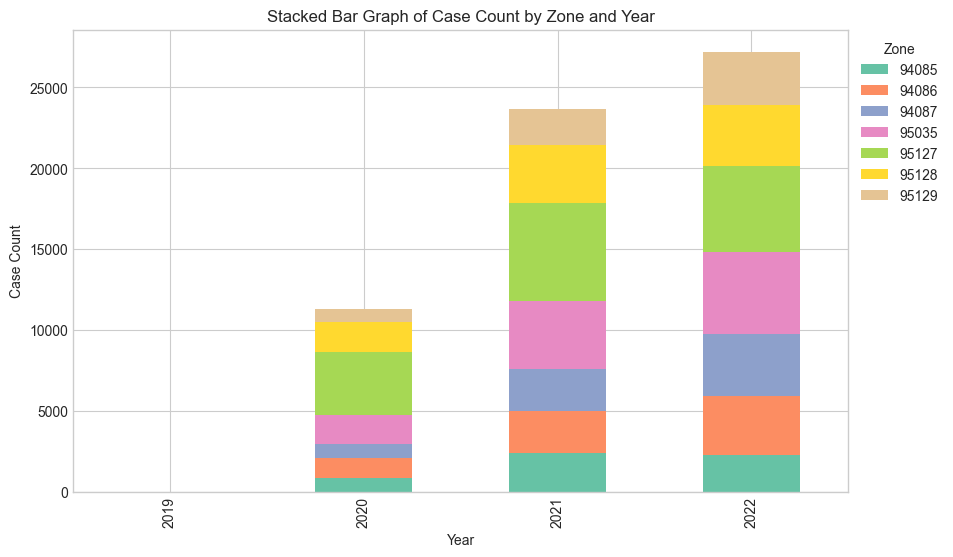

In [202]:
def plot_stacked_bar(df):
    df['Month'] = df['Start date'].dt.month
    df['Year'] = df['Start date'].dt.year

    grouped_data = df.groupby(['Year', 'zcta'])['case count'].sum().unstack()
    print(grouped_data)

    ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    ax.set_title('Stacked Bar Graph of Case Count by Zone and Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Case Count')
    ax.legend(title='Zone', loc='upper left', bbox_to_anchor=(1, 1))


    plt.show()

plot_stacked_bar(df)


- Comment peut-on efficacement graphiquement représenter le rapport entre la population et le nombre de tests effectués?

   population     test count
0       23223   106554.58156
1       36975  196044.595745
2       39741  210614.061409
3       50477   211426.58156
4       56668  293192.545548
5       66256  273129.393567
6       79655  306564.900214


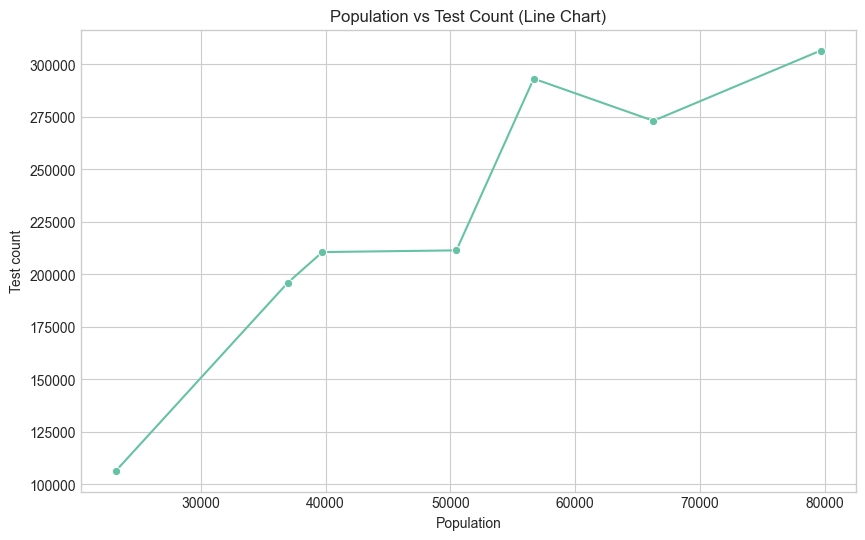

In [204]:
def plot_population_test_line():
    data = df[['population', 'test count']]
    grouped_data = data.groupby('population').sum().reset_index()
    print(grouped_data)

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='population', y='test count', data=grouped_data, marker='o')
    plt.title('Population vs Test Count (Line Chart)')
    plt.xlabel('Population')
    plt.ylabel('Test count')
    plt.show()

plot_population_test_line()


- Quelles sont les 5 zones les plus fortement impactées par le coronavirus?

zcta
94085     5472.66038
95129    6317.336215
94087    7383.129888
94086    7456.239116
95128    9218.699099
Name: case count, dtype: object


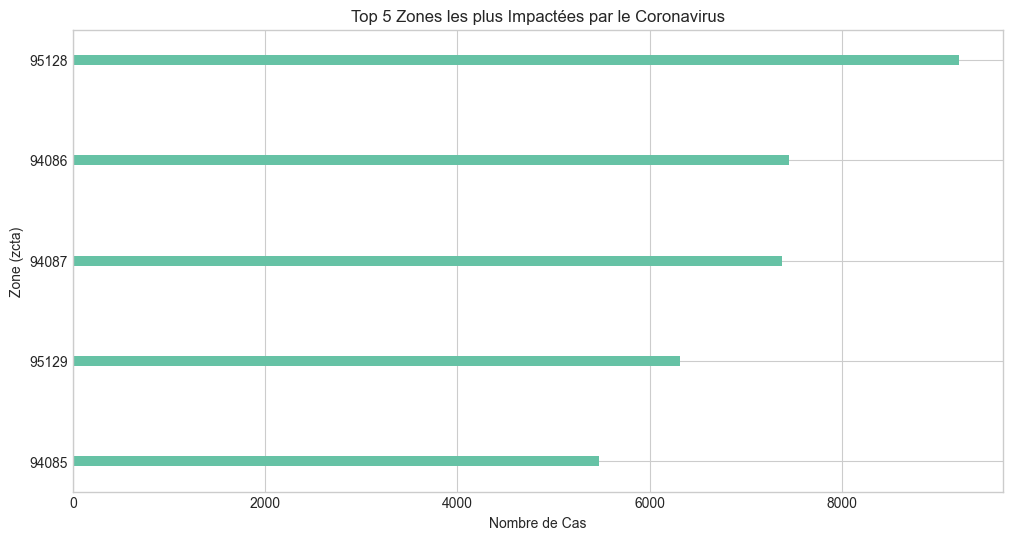

In [194]:
def plot_top_zones_impacted_matplotlib(n):
    grouped_data = df.groupby('zcta')['case count'].sum().sort_values(ascending=True).head(n)
    print(grouped_data)

    bar_width = 0.1

    grouped_data.plot.barh(figsize=(12, 6), width=bar_width)

    plt.title(f'Top {n} Zones les plus Impactées par le Coronavirus')
    plt.xlabel('Nombre de Cas')
    plt.show()

plot_top_zones_impacted_matplotlib(5)


- Quel est le rapport entre les cas confirmés, les tests effectués et les tests positifs a une periode choisie pour chaque zone ? 

    zcta positive tests test count case count
0  94085           23.0      409.0       20.0
1  94086           41.0      984.0       39.0
2  94087           48.0     1280.0       39.0
3  95035          106.0     1392.0       86.0
4  95127           49.0     1276.0       40.0
5  95128           20.0      803.0       14.0
6  95129           42.0      707.0       39.0


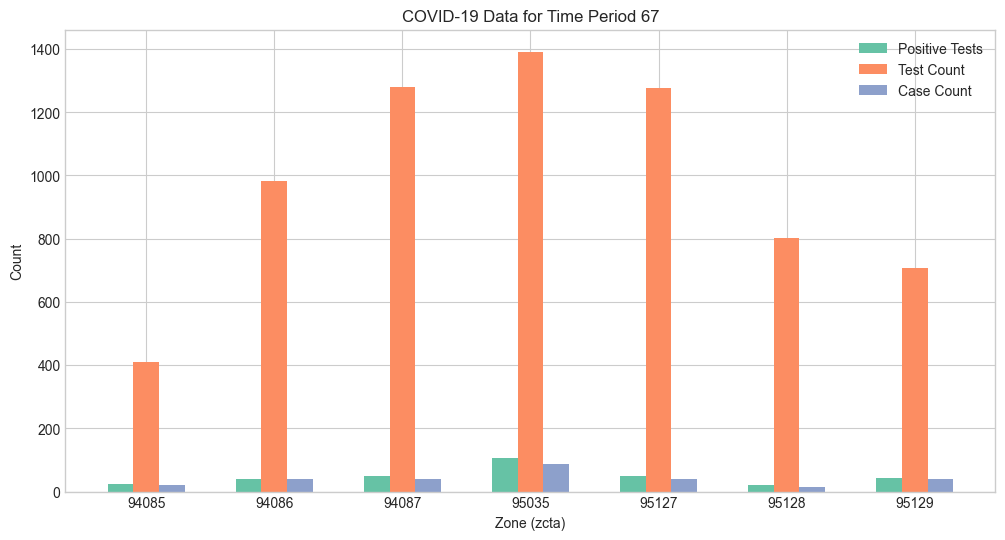

In [205]:
def plot_covid19_data(time_period):
    selected_data = df[(df['time_period'] == time_period)]
    grouped_data = selected_data.groupby('zcta')[['positive tests', 'test count', 'case count']].sum().reset_index()

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.2
    index = grouped_data.index

    print(grouped_data)

    ax.bar(index - bar_width, grouped_data['positive tests'], width=bar_width, label='Positive Tests')
    ax.bar(index, grouped_data['test count'], width=bar_width, label='Test Count')
    ax.bar(index + bar_width, grouped_data['case count'], width=bar_width, label='Case Count')

    ax.set_xticks(index)
    ax.set_xticklabels(grouped_data['zcta'])
    ax.set_xlabel('Zone (zcta)')
    ax.set_ylabel('Count')
    ax.set_title(f'COVID-19 Data for Time Period {time_period}')
    ax.legend()

    plt.show()

plot_covid19_data(67)  
